<a href="https://colab.research.google.com/github/VladousSparrowous/Optimal_routes_on_graphs_for_groups/blob/main/Graph_paths_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from tqdm import tqdm
from scipy import optimize
import random
import pickle

random.seed(42)

# работа с графом

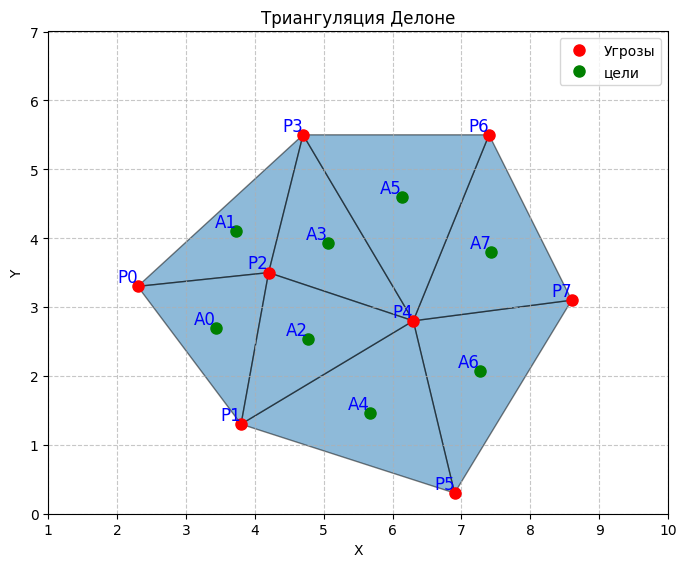

In [3]:
# считывание координат точек
all_points = list()
with open('/content/drive/MyDrive/data/points', 'r', encoding='UTF-8') as file:
  lines = file.readlines()
  for i in lines:
    point = list(map(float, i.split()))
    all_points.append(point)

points = np.array(all_points[1:-1])

# Выполнение триангуляции Делоне
tri = Delaunay(points)

# Отрисовка треугольников
fig, ax = plt.subplots(figsize=(8, 8))

for i, simplex in enumerate(tri.simplices):
    polygon = plt.Polygon(points[simplex], edgecolor='black', alpha=0.5, fill=True)
    ax.add_patch(polygon)

# барицентры
bars = list()
for i, simplex in enumerate(tri.simplices):
  bars.append([np.array([points[j][0] for j in simplex]).mean(), np.array([points[j][1] for j in simplex]).mean()])
bars = sorted(bars, key=lambda p: p[0])
bars = np.array(bars)

number_of_aims = len(bars) # число целей

# Отрисовка точек
ax.plot(points[:, 0], points[:, 1], 'o', color='red', markersize=8, label='Угрозы')


ax.plot(bars[:, 0], bars[:, 1], 'o', color='green', markersize=8, label='цели')

# Подписи точек
for i, (x, y) in enumerate(points):
    ax.text(x, y, f'P{i}', fontsize=12, ha='right', va='bottom', color='blue')

for i, (x, y) in enumerate(bars):
    ax.text(x, y, f'A{i}', fontsize=12, ha='right', va='bottom', color='blue')

# Настройка графика
ax.set_xlim(1, 10)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Триангуляция Делоне')
ax.legend(loc='upper right')

plt.show()

In [4]:
# точки входа и выхода
I = all_points[0]
I_neighbors = [0, 1, 4]# @param

O = all_points[-1]
O_neighbors = [ 5, 6, 7]# @param

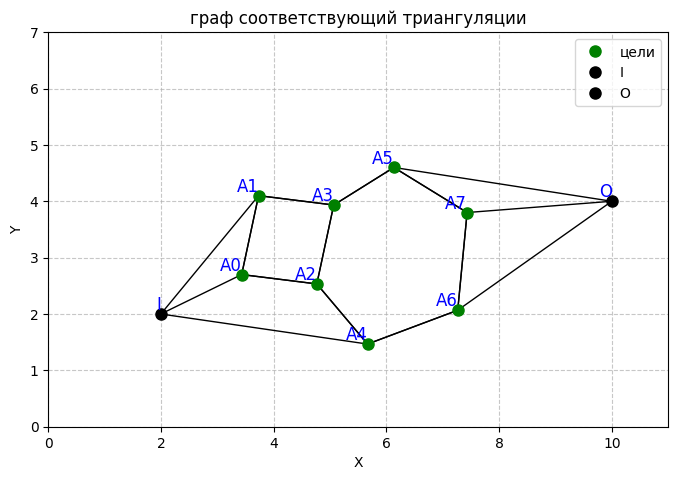

In [5]:

Bars_neigbors = dict() # таблица сопоставляющая цели соседние цели
Bars_neigbors['I'] = I_neighbors
Bars_neigbors['O'] = O_neighbors
# Отрисовка графа
fig, ax = plt.subplots(figsize=(8, 8))

simplex_bars = dict() # таблица сопоставляющая симплексу центр(цель)
for i in range(bars.shape[0]):
  n = int(tri.find_simplex(bars[i]))
  simplex_bars[n] = i

for i, simplex in enumerate(tri.simplices):
  neig = tri.neighbors[i]
  Bars_neigbors[simplex_bars[i]] = list()
  for j in neig:
    if j != -1:
      A = bars[simplex_bars[i]]
      B = bars[simplex_bars[j]]
      ax.plot([A[0], B[0]], [A[1], B[1]], color='black', linestyle='-', linewidth=1)
      Bars_neigbors[simplex_bars[i]].append(simplex_bars[j])

for i in I_neighbors:
  ax.plot([bars[i][0], I[0]], [bars[i][1], I[1]], color='black', linestyle='-', linewidth=1)
  Bars_neigbors[i].append('I')

for i in O_neighbors:
  ax.plot([bars[i][0], O[0]], [bars[i][1], O[1]], color='black', linestyle='-', linewidth=1)
  Bars_neigbors[i].append('O')

# точки
ax.plot(bars[:, 0], bars[:, 1], 'o', color='green', markersize=8, label='цели')

ax.plot(I[0], I[1], 'o', color='black', markersize=8, label='I')
ax.plot(O[0], O[1], 'o', color='black', markersize=8, label='O')

for i, (x, y) in enumerate(bars):
    ax.text(x, y, f'A{i}', fontsize=12, ha='right', va='bottom', color='blue')

ax.text(I[0], I[1], 'I', fontsize=12, ha='right', va='bottom', color='blue')
ax.text(O[0], O[1], 'O', fontsize=12, ha='right', va='bottom', color='blue')

# Настройка графика
ax.set_xlim(0, 11)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('граф соответствующий триангуляции')
ax.legend(loc='upper right')

plt.show()

In [6]:
print(f'I: {I_neighbors}')
for i in range(len(Bars_neigbors) - 2):
  print(f'{i}: {Bars_neigbors[i]}')
print(f'O: {O_neighbors}')

I: [0, 1, 4]
0: [1, 2, 'I']
1: [0, 3, 'I']
2: [4, 3, 0]
3: [2, 5, 1]
4: [6, 2, 'I']
5: [3, 7, 'O']
6: [7, 4, 'O']
7: [6, 5, 'O']
O: [5, 6, 7]


# поиск всех возможных путей
в результате получается словарь All_roots

в All_roots будут данные о всех маршрутах в формате
```
All_roots[i] = (
    конечная точка(везде 'O'),
    словар с данными о шагах до 'O',
    словарь переходо (вершина: [следующая_1, следующая_2...]
)
```


In [7]:
# поиск всех путей

from more_itertools import powerset
from itertools import product

# множество всех подмножеств кроме пустого
def all_subsets(s):
    return [list(subset) for subset in powerset(s) if len(subset) > 0]

# шаг в глубину
def step(layer, times, connections):

  Possible_combine = list()

  for i in layer:

    if i == "O": # условие конечности O
      Possible_combine.append([['O']])
      continue

    Possible_neig = set()

    for j in Bars_neigbors[i]:

      if times.get(j, -1) == -1 or j == 'O': # O может быть посещена несколько раз
        Possible_neig.add(j)

    if len(Possible_neig) == 0: # условие отсутсвия соседей
      return 0

    Possible_neig = all_subsets(Possible_neig) # все возможные переходы из данной цели
    Possible_combine.append(Possible_neig)

  Possible_combine = tuple(Possible_combine) # кортеж всех возможных переходов для каждой из текущих целей

  list_of_conditions = list()

  for condition in product(*Possible_combine):

    new_layer = list() # следующий слой из данного состояния
    for j in condition:
      new_layer += j
    new_layer = list(set(new_layer))

    new_times = times.copy() # время для этого слоя

    for key in new_times:
      new_times[key] += 1

    for j in new_layer:
      new_times[j] = 1

    new_connections = connections.copy()
    for i in range(len(layer)):
      new_connections[layer[i]] = condition[i]

    list_of_conditions.append((new_layer, new_times, new_connections))
  return list_of_conditions


In [8]:
# начальные параметры алгоритма

All_roots = {}
count = 0

Time = dict()
Time['I'] = 1
connections = dict()
iter = step(['I'], Time, connections) # первый шаг
end = True

while end:

  end = False
  new_iter = list()

  for i in iter:

    if i[0][0] == 'O' and len(i[0]) == 1: # конечное условие(если группы пришли в O)

      all_aims = True # проверка посещения всех целей
      for j in range(len(bars)):
        if not (j in i[2]):
          all_aims = False

      if all_aims:
        All_roots[count] = i
        count += 1
      continue

    end = True
    part = step(*i) # шаг
    if part == 0:
      continue

    for j in part:
      new_iter.append(j)

  iter = new_iter


In [9]:
'''
в All_roots будут данные о всех маршрутах в формате
All_roots[i] = (
    конечная точка(везде 'O'),
    словар с данными о шагах до 'O',
    словарь переходо (вершина: [следующая_1, следующая_2...])
)
'''
number_of_roots = len(All_roots)
print(number_of_roots)

for n, root in All_roots.items():
    print('+++++++++++++++++++++++++++++++')
    print(f'root number: {n}')
    print(f'steps: {root[1]}')
    print(f'from_to dict: {root[2]}')
    print('+++++++++++++++++++++++++++++++')


# Сохранение
with open('/content/drive/MyDrive/data/all_roots.pkl', 'wb') as f:
    pickle.dump(All_roots, f)

104
+++++++++++++++++++++++++++++++
root number: 0
steps: {'I': 6, 0: 5, 1: 5, 2: 4, 3: 4, 4: 3, 5: 3, 6: 2, 7: 2, 'O': 1}
from_to dict: {'I': [0, 1], 0: [2], 1: [3], 2: [4], 3: [5], 4: [6], 5: [7], 6: ['O'], 7: ['O']}
+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
root number: 1
steps: {'I': 6, 0: 5, 1: 5, 2: 4, 3: 4, 4: 3, 5: 3, 'O': 1, 6: 2, 7: 2}
from_to dict: {'I': [0, 1], 0: [2], 1: [3], 2: [4], 3: [5], 4: [6], 5: ['O', 7], 'O': ['O'], 6: ['O'], 7: ['O']}
+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
root number: 2
steps: {'I': 6, 0: 5, 4: 5, 1: 4, 2: 4, 6: 4, 3: 3, 7: 3, 'O': 1, 5: 2}
from_to dict: {'I': [0, 4], 0: [1], 4: [2, 6], 1: [3], 2: [3], 6: [7], 3: [5], 7: ['O'], 'O': ['O'], 5: ['O']}
+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
root number: 3
steps: {'I': 6, 0: 5, 4: 5, 1: 4, 2: 4, 6: 4, 3: 3, 7: 3, 5: 2, 'O': 1}
from_to dict: {'I': [0, 4], 0: [1], 4: [2, 6], 1: [3], 2: [3], 6: [7], 3: [5], 7: [5], 5: ['O']}
+++++++

# фунции отрисовки

plots(W, H, raiting=None) - строит график W на H; raiting - массив с номерами нужных путей, при raiting == None для случайных маршрутов

plot_graph(raiting=None) - строит один график для маршрута под номером raiting, для случайного при raiting == None

In [10]:
# функция для задания векторов
def vectorize(connect):
  X = list()
  Y = list()
  U = list()
  V = list()
  for key, mas in connect.items():
    if key == 'O':
      continue
    x0 = 0
    y0 = 0
    if key == 'I':
      x0 = I[0]
      y0 = I[1]
      X += [x0] * len(mas)
      Y += [y0] * len(mas)
    else:
      x0 = bars[key][0]
      y0 = bars[key][1]
      X += [x0] * len(mas)
      Y += [y0] * len(mas)

    plusU = list()
    plusV = list()
    for i in mas:
      if i == 'O':
        plusU.append(O[0] - x0)
        plusV.append(O[1] - y0)
      else:
        plusU.append(bars[i][0] - x0)
        plusV.append(bars[i][1] - y0)
    U += plusU
    V += plusV
  return [(X, Y), (U, V)]


In [11]:
# функция построения графиков
def plots(W, H, raiting=None):
  fig, axes = plt.subplots(W, H, figsize=(10, 8))
  counter = 0
  for i in range(W):
    for j in range(H):
      axes[i, j].plot(bars[:, 0], bars[:, 1], 'o', color='green', markersize=4, label='цели')

      axes[i, j].plot(I[0], I[1], 'o', color='black', markersize=4, label='I')
      axes[i, j].plot(O[0], O[1], 'o', color='black', markersize=4, label='O')

      for k, (x, y) in enumerate(bars):
          axes[i, j].text(x, y, f'A{k}', fontsize=6, ha='right', va='bottom', color='blue')

      axes[i, j].text(I[0], I[1], 'I', fontsize=6, ha='right', va='bottom', color='blue')
      axes[i, j].text(O[0], O[1], 'O', fontsize=6, ha='right', va='bottom', color='blue')

      p = 0

      if raiting == None:
        p = random.randint(0, number_of_roots)
      else:
        p = raiting[counter]
        counter += 1

      coord = vectorize(All_roots[p][2])


      # Начальные точки векторов
      x = coord[0][0]
      y = coord[0][1]

      # Компоненты векторов
      u = coord[1][0]
      v = coord[1][1]

      axes[i, j].quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='r', headwidth=7)

      # Настройка графика
      axes[i, j].set_xlim(0, 11)
      axes[i, j].set_ylim(0, 7)
      axes[i, j].set_aspect('equal')
      axes[i, j].grid(True, linestyle='--', alpha=0.7)
      axes[i, j].set_xlabel('X')
      axes[i, j].set_ylabel('Y')
      axes[i, j].legend([f'{p}'])
  axes[0, 1].set_title('примеры')
  plt.show()

In [12]:
# функция построения графика

def plot_graph(raiting=None):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.plot(bars[:, 0], bars[:, 1], 'o', color='green', markersize=4, label='цели')

  ax.plot(I[0], I[1], 'o', color='black', markersize=4, label='I')
  ax.plot(O[0], O[1], 'o', color='black', markersize=4, label='O')

  for k, (x, y) in enumerate(bars):
    ax.text(x, y, f'A{k}', fontsize=12, ha='right', va='bottom', color='blue')

  ax.text(I[0], I[1], 'I', fontsize=12, ha='right', va='bottom', color='blue')
  ax.text(O[0], O[1], 'O', fontsize=12, ha='right', va='bottom', color='blue')

  p = 0

  if raiting == None:
    p = random.randint(0, number_of_roots)
  else:
    p = raiting

  coord = vectorize(All_roots[p][2])


  # Начальные точки векторов
  x = coord[0][0]
  y = coord[0][1]

  # Компоненты векторов
  u = coord[1][0]
  v = coord[1][1]

  ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='r', headwidth=4)

  # Настройка графика
  ax.set_xlim(0, 11)
  ax.set_ylim(0, 7)
  ax.set_aspect('equal')
  ax.grid(True, linestyle='--', alpha=0.7)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.legend([f'{p}'])
  ax.set_title('пример')
  plt.show()

# нахождение оптимального пути

для нахождения оптимального пути строятся матрицы соответствия вершин входящим и выходящим группам по которрым строится система неравенств для задачи линейного программировани:

# построение матрицы
\begin{array}{c|ccc}
& \text G_{ab} & \cdots & \text G_{cd} \\ \hline
\text A_{0} & x^{11} & \cdots & x^{1m} \\
\vdots & \vdots & \ddots & \vdots \\
\text A_{n} & x^{n1} & \cdots & x^{nm} \\
\end{array}

$x^{ij} = 0$, если соответсвующая G не входит в вершину i;

$x^{ij} = -1$, если соответсвующая G входит в вершину i;

$x^{ij} = 1$, если соответсвующая G выходит в вершину i;

# задача линейного программирования
по матрице строится система:

\begin{cases}
&\sum_{k} G_{ik} = p_i \sum_{j} G_{ji}\\
&G_{ji} \geq 1
\end{cases}

и дополняется минимизируемым функционалом потерь:

$\Delta G = G_I - G_O \xrightarrow{}min$

результатом этого блока будут функции:
```
raiting_of_roots(P, init='raiting')
```
 где P - вектор вероятностей, парамет init овечает за результат функции, при 'raiting' вернёт все пути в порядке возрастания функционала, при 'best' вернёт лучший путь в формате (минимум функционала, группы, номер пути, число шагов).
 ```
 n_better(n, Rt)
 n_worse(n, Rt)
 ```
 по рэйтингу и числу n выводят данные для каждого маршрута(результат по функционалу, номер, каждую группу) возвращают массив с номерами путей

In [65]:
# построение матриц

Matrixs = {}
for root in range(number_of_roots):

    G = list()
    connect = All_roots[root][2]
    matrix = list()

    for next in connect['I']:

        G.append(f'GI{next}')
        vect = [0] * (number_of_aims + 1)
        vect[next] = -1
        vect[-1] = 1
        matrix.append(vect)

    for present in range(number_of_aims):
        for next in connect[present]:
            G.append(f'G{present}{next}')
            vect = [0] * (number_of_aims + 1)
            vect[present] = 1
            if next == 'O':
                vect[-1] = -1
            else:
                vect[next] = -1
            matrix.append(vect)

    matrix = np.array(matrix).T
    Matrixs[root] = (G, matrix)

'''
в Matrixs записаны пары
группы и соответсвующие матрицы сопоставляющие группы с вершинами
например:
Matrixs[i] = (
    G = ['GI0', 'G01', 'G13', 'G24', 'G32', 'G46', 'G5O', 'G67', 'G75'],
    матрица - M(dim: число вершин + 1 * число групп)
)
M[j] = [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0] -
это соответсвует вершине Aj в которую входит G[0] и выходит G[1]
в M[-1] будет функционал соответствующий O - I
'''

"\nв Matrixs записаны пары\nгруппы и соответсвующие матрицы сопоставляющие группы с вершинами\nнапример:\nMatrixs[i] = (\n    G = ['GI0', 'G01', 'G13', 'G24', 'G32', 'G46', 'G5O', 'G67', 'G75'],\n    матрица - M(dim: число вершин + 1 * число групп)\n)\nM[j] = [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0] -\nэто соответсвует вершине Aj в которую входит G[0] и выходит G[1]\nв M[-1] будет функционал соответствующий O - I\n"

In [66]:
print(Matrixs[0])

(['GI0', 'GI1', 'G02', 'G13', 'G24', 'G35', 'G46', 'G57', 'G6O', 'G7O'], array([[-1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, -1,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  1],
       [ 1,  1,  0,  0,  0,  0,  0,  0, -1, -1]]))


In [67]:
#функция решающая задачу линейного программирования

def solve_matrix(p, A, c):

    A = np.array(A)
    p = np.array(p)
    c = np.array(c)

    A_ = np.zeros_like(A, dtype=float)

    # Для случаев, где A == -1, нужно взять p[i] для каждой строки i
    # Создаём массив индексов строк
    rows, cols = np.where(A == -1)
    A_[rows, cols] = -p[rows]

    # Для A == 1
    A_[A == 1] = 1

    b_ = np.zeros(A_.shape[0], dtype=float)

    bounds = [(1, None) for _ in range(A_.shape[1])]

    res_ = optimize.linprog(c, A_ub=A_, b_ub=b_, bounds=bounds, method='highs')
    return((res_.fun, res_.x))

In [68]:
# вычисления рейтинга решений или лучшего решения от вектора P

from functools import reduce

def raiting_of_roots(P, init='raiting'):

    p = reduce(lambda x, y: x * y, P, 1)
    coef = p / (1 - p) # коэффициент нормировки (1 будет у пути прошедшего последовательно по всем вершинам)

    Raiting = list()
    for i in range(number_of_roots):

        A = Matrixs[i][1][:-1]
        c = Matrixs[i][1][-1]

        Answer = solve_matrix(P, A, c)
        Groups = list()
        for j in range(len(c)):
            Groups.append(f'{Matrixs[i][0][j]} = {Answer[1][j]}')

        # добавляем (минимум функционала, группы, номер пути, число шагов)
        Raiting.append((Answer[0] * coef, Groups, i, All_roots[i][1]["I"] - 1))

    if init == 'raiting':
        Raiting = sorted(Raiting, key=lambda s: s[0])
        return Raiting

    if init == 'best':
        Raiting_min = min(Raiting, key=lambda s: s[0])
        return Raiting_min


In [69]:
# функции вывода n лучших и n худших

def n_better(n, Rt):
    roots = []
    for i in range(n):
        print(f'#{i+1}')
        print(f'n = {Rt[i][2]}')
        roots.append(Rt[i][2])
        print(f'steps = {Rt[i][3]}')
        print(Rt[i][0])
        print(*Rt[i][1], sep="\n")
        print()

    return roots

def n_worse(n, Rt):
    roots = []
    for i in range(n):
        print(f'#{number_of_roots - i}')
        print(f'n = {Rt[-1 -i][2]}')
        roots.append(Rt[-1 -i][2])
        print(f'steps = {Rt[-1 -i][3]}')
        print(Rt[-1 - i][0])
        print(*Rt[-1 - i][1], sep="\n")
        print()
    return roots

# ML часть
предсказание маршрута по вектору задающему вероятности

In [17]:
# генерация данных для обучения

def data(N_samples):
    P_matrix = []
    classes = []
    functional = []

    for i in tqdm(range(N_samples)):
        p = np.random.random(len(bars))
        P_matrix.append(p)

        best = raiting_of_roots(p, 'best')

        classes.append(best[2])
        functional.append(best[0])

    return np.array(P_matrix), np.array(classes), np.array(functional)

In [18]:
X, y_class, y_reg = data(100000)

100%|██████████| 100000/100000 [7:50:09<00:00,  3.54it/s]


In [19]:
import pickle

# Сохранение
with open('/content/drive/MyDrive/data/data_nir.pkl', 'wb') as f:
    pickle.dump({'X': X, 'y_class': y_class, 'y_reg': y_reg}, f)

In [20]:
# Загрузка

with open('/content/drive/MyDrive/data/all_roots.pkl', 'rb') as f:
    All_roots = pickle.load(f)
    number_of_roots = len(All_roots)

with open('/content/drive/MyDrive/data/data_nir.pkl', 'rb') as f:
    data = pickle.load(f)
    X = data['X']
    y_class = data['y_class']
    y_reg = data['y_reg']

# print(X, y_class, y_reg, sep='\n')

In [ ]:
unique, counts = np.unique(y_class, return_counts=True)
freq_dict = dict(zip(unique, counts))

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class,
    test_size=0.2,
    stratify=y_class,
    random_state=42
)

classes = np.array(list(freq_dict.keys()))
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))

model = LogisticRegression(
    class_weight=class_weights_dict,
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Micro average
f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"Micro-average F1: {f1_micro:.4f}")

# Macro average
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro-average F1: {f1_macro:.4f}")

# weighted
f1_weight = f1_score(y_test, y_pred, average='weighted')
print(f"weighted F1: {f1_weight:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Micro-average F1: 0.4941
Macro-average F1: 0.3150
weighted F1: 0.5530


In [86]:

xgb_to_y = {i: unique[i] for i in range(len(unique))}
y_to_xgb = {xgb_to_y[i]: i for i in xgb_to_y}

y_class_xgb = [y_to_xgb[i] for i in y_class]
freq_dict_xgb = {y_to_xgb[i]: freq_dict[i] for i in freq_dict}

[ 0  2  3  8  9 23 31 37 42 43 48 50 51 52 56 74 78 82 84 86 90]
{0: np.int64(0), 1: np.int64(2), 2: np.int64(3), 3: np.int64(8), 4: np.int64(9), 5: np.int64(23), 6: np.int64(31), 7: np.int64(37), 8: np.int64(42), 9: np.int64(43), 10: np.int64(48), 11: np.int64(50), 12: np.int64(51), 13: np.int64(52), 14: np.int64(56), 15: np.int64(74), 16: np.int64(78), 17: np.int64(82), 18: np.int64(84), 19: np.int64(86), 20: np.int64(90)}


In [90]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split


X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X, y_class_xgb,
    test_size=0.2,
    stratify=y_class_xgb,
    random_state=42
)

sample_weights = compute_sample_weight('balanced', y_train_xgb)

model_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    num_class=len(freq_dict_xgb),
    eval_metric='mlogloss',
    random_state=42
)

model_xgb.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weights)

y_pred_xgb = model_xgb.predict(X_test_xgb)

# Micro average
f1_micro_xgb = f1_score(y_test_xgb, y_pred_xgb, average='micro')
print(f"Micro-average F1: {f1_micro_xgb:.4f}")

# Macro average
f1_macro_xgb = f1_score(y_test_xgb, y_pred_xgb, average='macro')
print(f"Macro-average F1: {f1_macro_xgb:.4f}")

# weighted
f1_weight_xgb = f1_score(y_test_xgb, y_pred_xgb, average='weighted')
print(f"weighted F1: {f1_weight_xgb:.4f}")

Micro-average F1: 0.8134
Macro-average F1: 0.5513
weighted F1: 0.8278


In [122]:
def compare_model_xgb_to_true(n):
    result = []
    for i in tqdm(range(n)):
        p = np.random.random(number_of_aims)
        Rt = raiting_of_roots(p)
        y_pred = xgb_to_y[model_xgb.predict(p.reshape((1, number_of_aims)))[0]]
        if Rt[0][2] == y_pred:
            result.append(('succes', y_pred))
        else:
            position = -1
            for i in range(len(Rt)):
                if Rt[i][2] == y_pred:
                    position = i
                    break

            result.append((f'fail_y_pred_position_is_{position}', y_pred, Rt[0][2]))
    return result

# Примеры, эксперименты и статистика

/tmp/ipython-input-2363712477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Значения', y='Частота', data=df, palette='viridis')


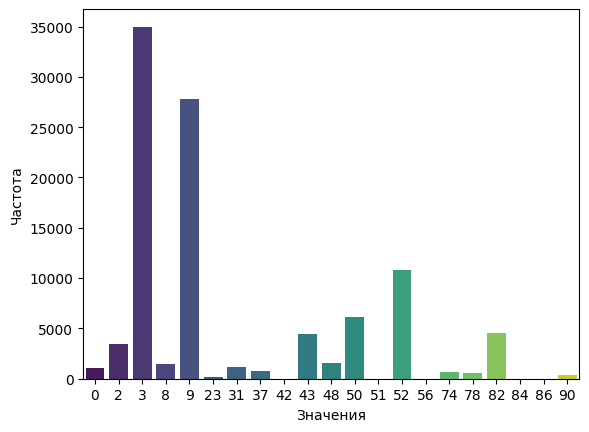

In [21]:
import pandas as pd
import seaborn as sns

unique, counts = np.unique(y_class, return_counts=True)
freq_dict = dict(zip(unique, counts))

df = pd.DataFrame(list(freq_dict.items()), columns=['Значения', 'Частота'])
sns.barplot(x='Значения', y='Частота', data=df, palette='viridis')

plt.show()

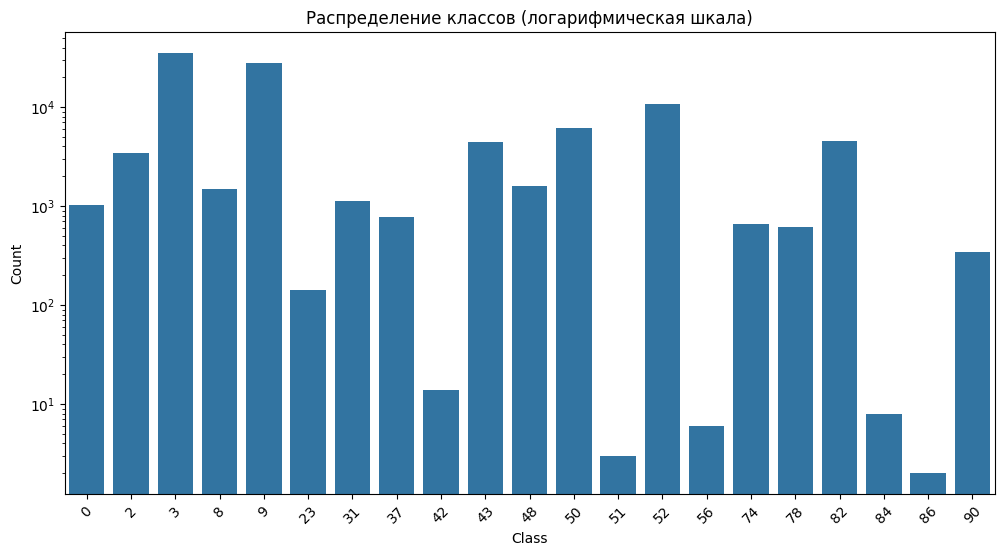

Самые редкие классы:
    Class  Count
7      37    780
15     74    653
16     78    615
20     90    341
5      23    142
8      42     14
18     84      8
14     56      6
12     51      3
19     86      2


In [73]:
df_dist = pd.DataFrame(list(freq_dict.items()), columns=['Class', 'Count'])
df_dist = df_dist.sort_values('Count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=df_dist)
plt.xticks(rotation=45)
plt.title('Распределение классов (логарифмическая шкала)')
plt.yscale('log')
plt.show()

print("Самые редкие классы:")
print(df_dist.tail(10))

In [46]:
raiting = list(map(int, sorted(freq_dict, key=lambda x: freq_dict[x])))

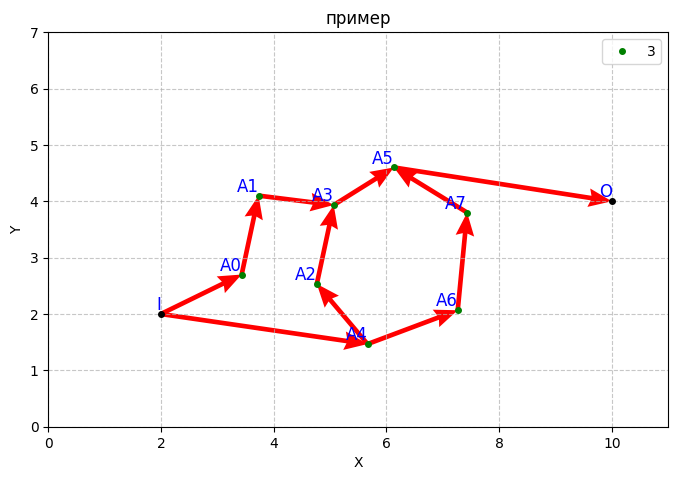

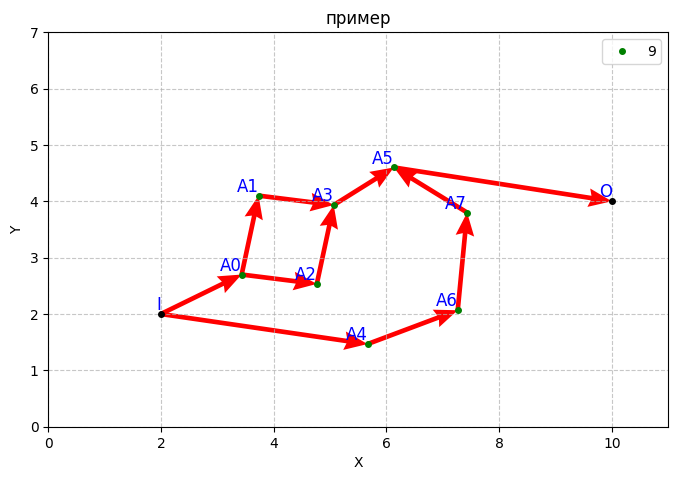

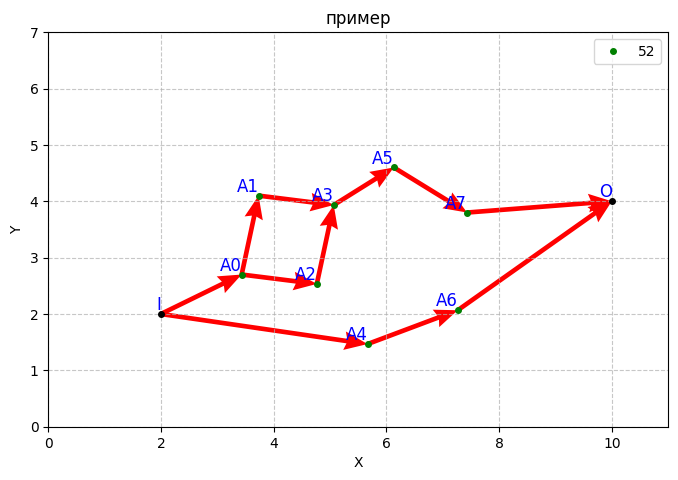

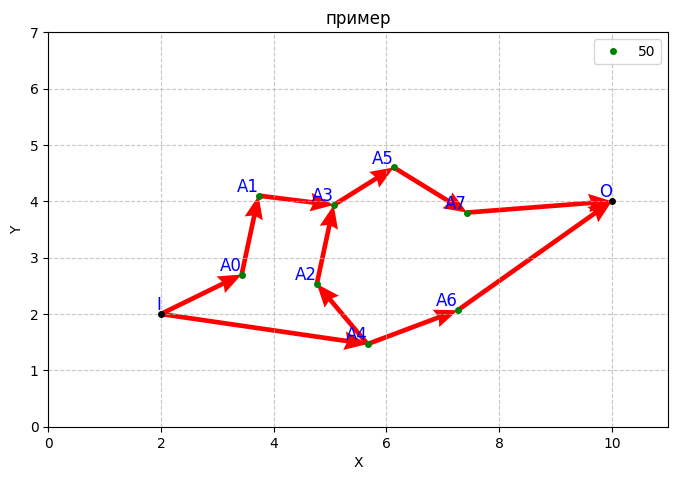

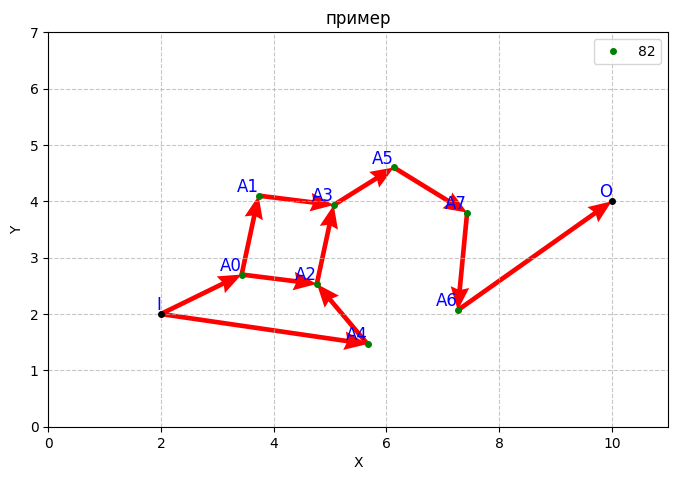

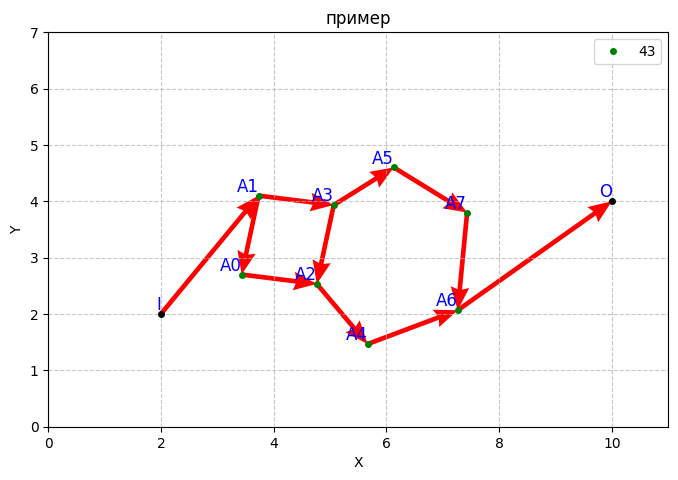

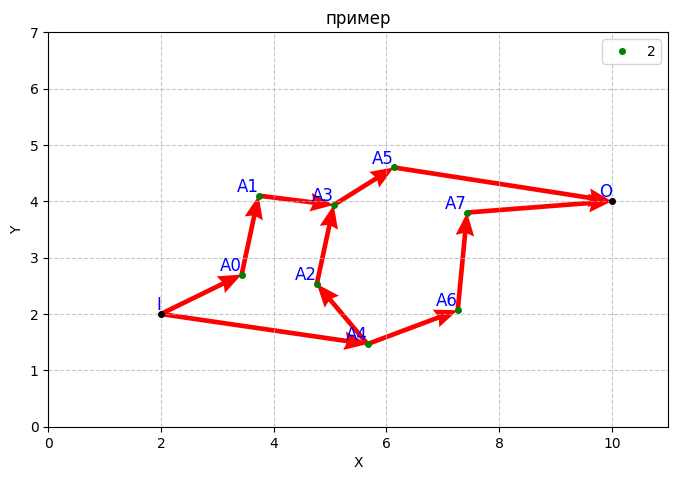

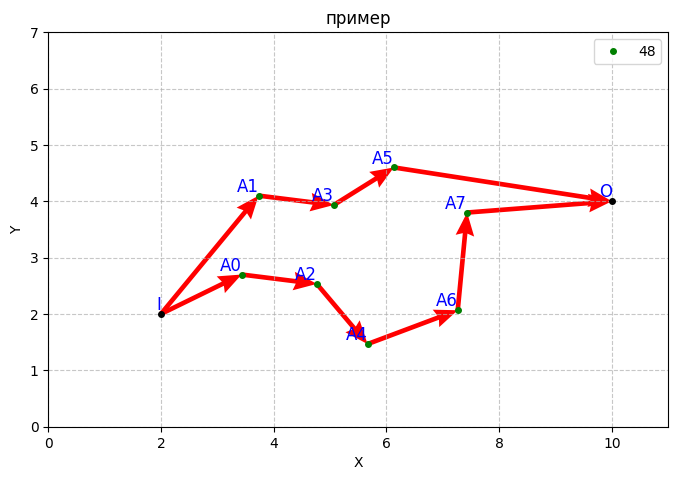

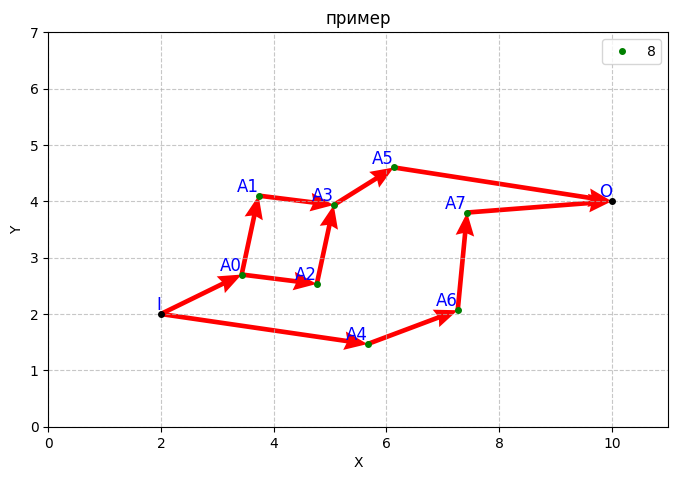

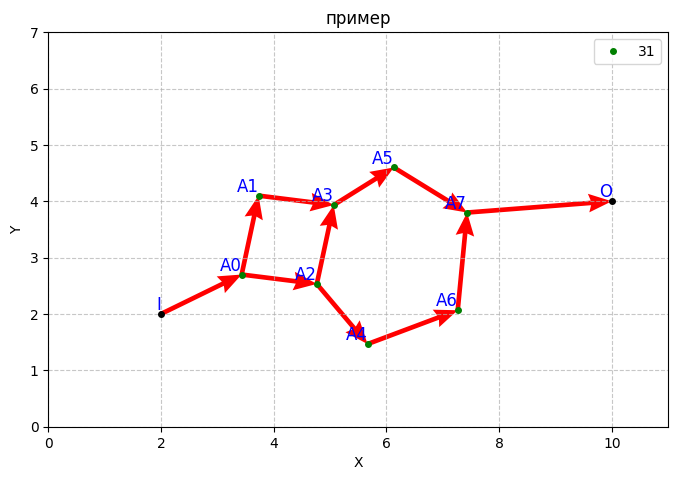

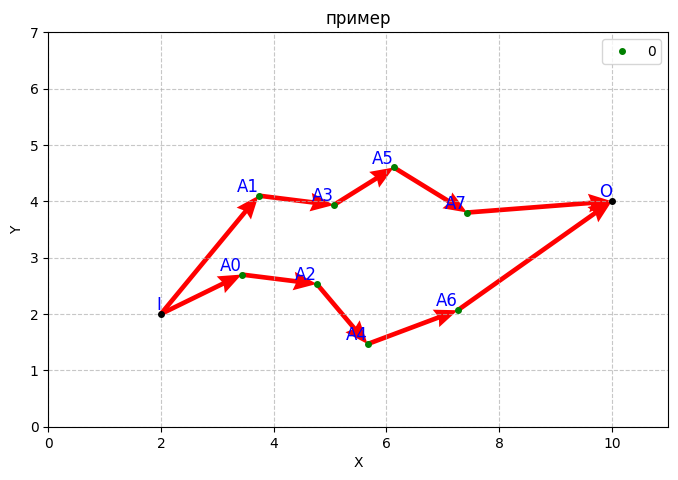

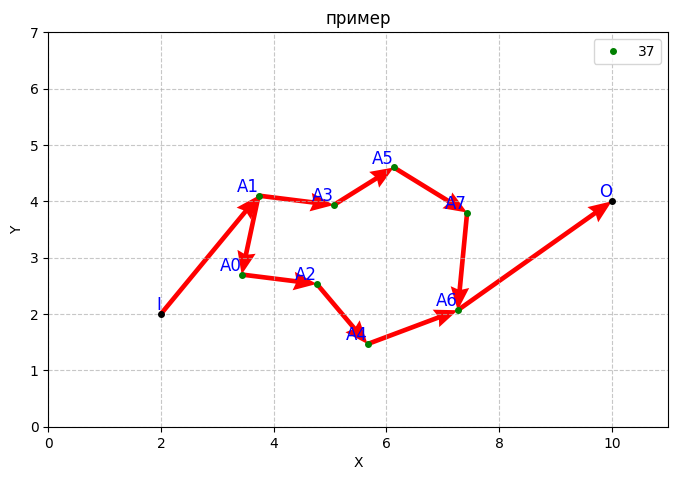

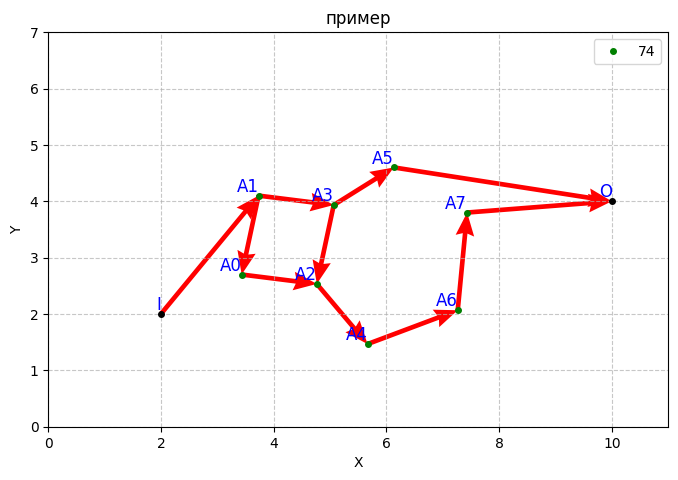

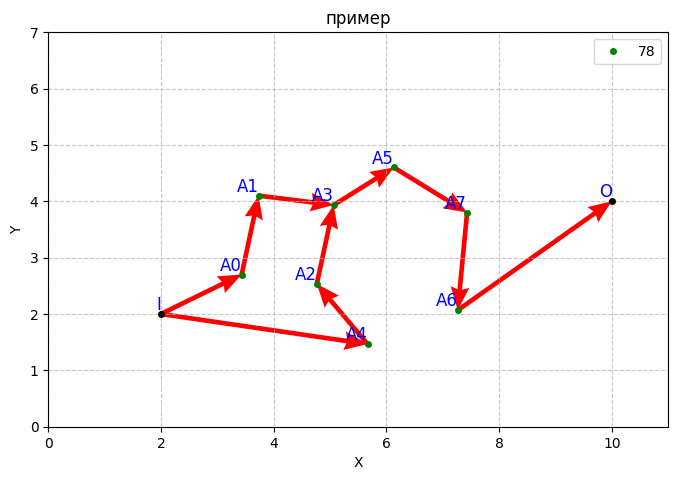

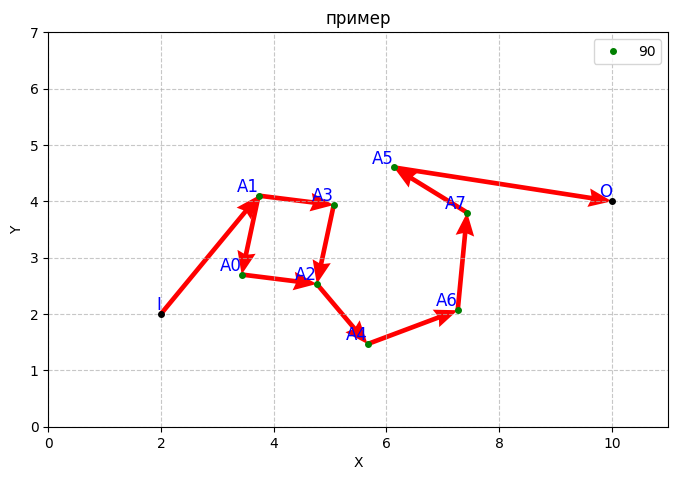

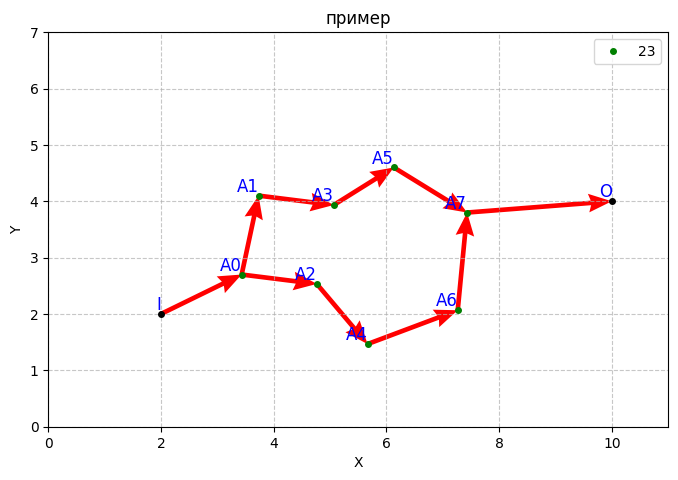

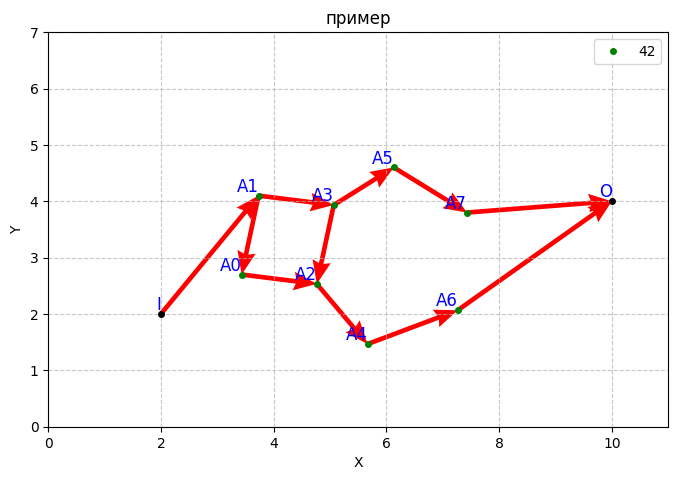

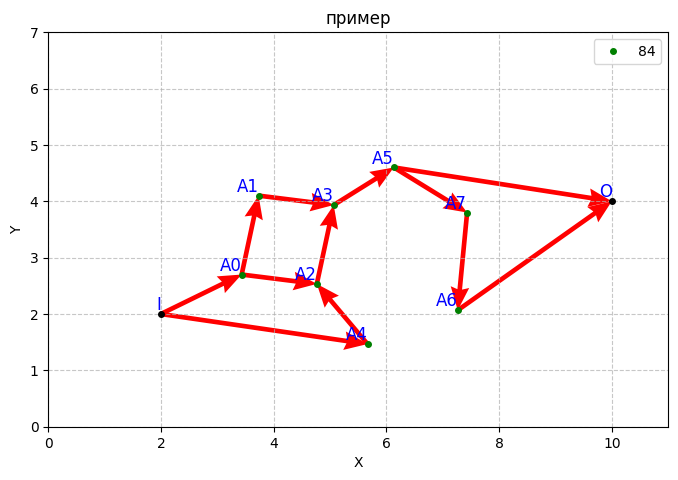

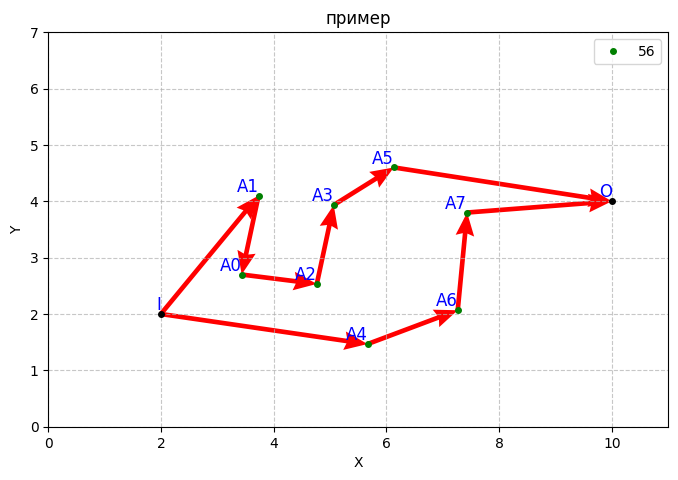

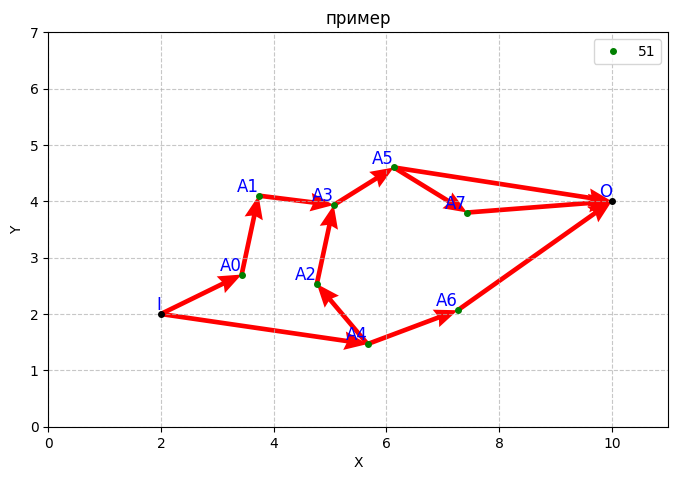

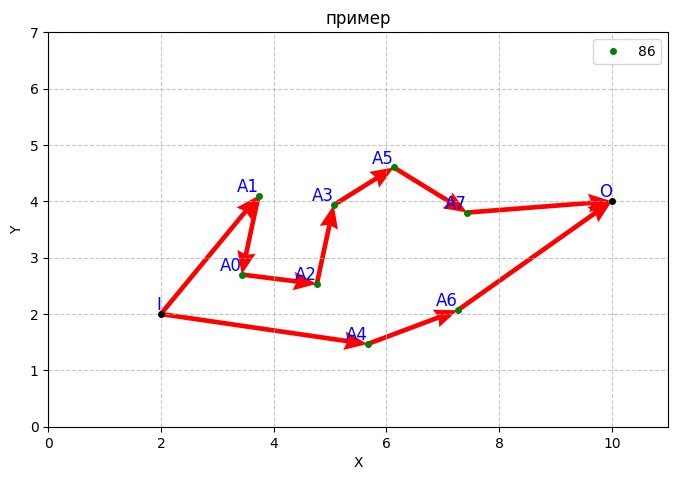

In [53]:
for root in raiting[::-1]:
    plot_graph(root)

In [70]:
index_y_86 = np.where(y_class == 86)[0]
p_86 = X[index_y_86]

Rt_1 = raiting_of_roots(p_86[0])
Rt_2 = raiting_of_roots(p_86[1])
print(*n_better(3, Rt_1))
print(*n_better(3, Rt_2))

#1
n = 86
steps = 7
0.26676931349145744
GI1 = 4.224038759443659
GI4 = 19.63679514619097
G02 = 1.2718197951375458
G10 = 2.0279441326378347
G23 = 1.2405025616270446
G35 = 1.1513437237159965
G46 = 11.896074242266113
G57 = 1.107054025236726
G6O = 1.0
G7O = 1.0

#2
n = 52
steps = 6
0.2682305509000893
GI0 = 4.956031967666304
GI4 = 19.63679514619097
G01 = 2.082916729046805
G02 = 1.0252456016450506
G13 = 1.0
G23 = 1.0
G35 = 1.856253681904361
G46 = 11.896074242266113
G57 = 1.7848476246348297
G6O = 1.0
G7O = 1.612249794451692

#3
n = 50
steps = 6
0.26893334960578635
GI0 = 3.3212557121638717
GI4 = 21.3291633547305
G01 = 2.082916729046805
G13 = 1.0
G23 = 1.0
G35 = 1.856253681904361
G42 = 1.0252456016450506
G46 = 11.896074242266113
G57 = 1.7848476246348297
G6O = 1.0
G7O = 1.612249794451692

86 52 50
#1
n = 86
steps = 7
0.5425638287251953
GI1 = 2.040070825277923
GI4 = 5.451876863178772
G02 = 1.7326260962659223
G10 = 1.9627575737699943
G23 = 1.3805376316503901
G35 = 1.299132257198121
G46 = 4.26565155

In [126]:
print(*compare_model_xgb_to_true(100), sep='\n')

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]

('fail_y_pred_position_is_1', np.int64(8), 9)
('fail_y_pred_position_is_2', np.int64(50), 52)
('fail_y_pred_position_is_12', np.int64(31), 9)
('succes', np.int64(9))
('succes', np.int64(8))
('succes', np.int64(43))
('succes', np.int64(3))
('fail_y_pred_position_is_5', np.int64(43), 9)
('succes', np.int64(3))
('succes', np.int64(3))
('succes', np.int64(9))
('succes', np.int64(50))
('succes', np.int64(8))
('succes', np.int64(9))
('fail_y_pred_position_is_14', np.int64(0), 9)
('succes', np.int64(50))
('succes', np.int64(3))
('succes', np.int64(9))
('succes', np.int64(43))
('succes', np.int64(9))
('succes', np.int64(3))
('fail_y_pred_position_is_1', np.int64(37), 0)
('fail_y_pred_position_is_3', np.int64(2), 8)
('succes', np.int64(3))
('succes', np.int64(9))
('fail_y_pred_position_is_3', np.int64(31), 52)
('succes', np.int64(9))
('succes', np.int64(82))
('succes', np.int64(82))
('succes', np.int64(9))
('succes', np.int64(9))
('succes', np.int64(3))
('succes', np.int64(50))
('succes', np.in

In [127]:
P = [1 / 2] * number_of_aims
Rt = raiting_of_roots(P)

top = n_better(4, Rt)

#1
n = 3
steps = 5
0.058823529411764705
GI0 = 4.0
GI4 = 12.0
G01 = 2.0
G13 = 1.0
G23 = 1.0
G35 = 1.0
G42 = 2.0
G46 = 4.0
G5O = 1.0
G67 = 2.0
G75 = 1.0

#2
n = 9
steps = 5
0.058823529411764705
GI0 = 8.0
GI4 = 8.0
G01 = 2.0
G02 = 2.0
G13 = 1.0
G23 = 1.0
G35 = 1.0
G46 = 4.0
G5O = 1.0
G67 = 2.0
G75 = 1.0

#3
n = 15
steps = 5
0.058823529411764705
GI0 = 6.0
GI4 = 10.0
G01 = 2.0
G02 = 1.0
G13 = 1.0
G23 = 1.0
G35 = 1.0
G42 = 1.0
G46 = 4.0
G5O = 1.0
G67 = 2.0
G75 = 1.0

#4
n = 6
steps = 5
0.07058823529411765
GI0 = 4.0
GI4 = 16.0
G01 = 2.0
G13 = 1.0
G23 = 1.0
G35 = 1.0
G42 = 2.0
G46 = 6.0
G5O = 1.0
G6O = 1.0
G67 = 2.0
G75 = 1.0



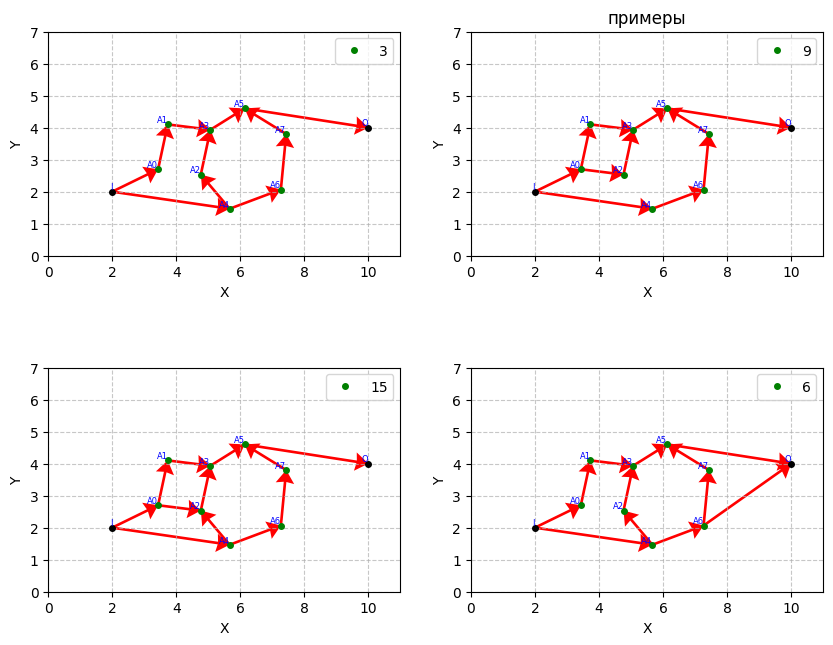

In [290]:
plots(2, 2, top)